# 安装框架
```bash
pip install pyxq==0.1.4
```

In [60]:
%matplotlib notebook
import pyxq as xq
from pyxq.msg import pa,md,td
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
from collections.abc import Iterable
from collections import namedtuple,defaultdict
import typing as tp
import matplotlib.pyplot as plt
import rqrisk as rq
rq.risk.APPROX_BDAYS_PER_YEAR=365

In [ ]:
help(xq)

Help on package pyxq:

NAME
    pyxq - Top-level package for pyxq.

PACKAGE CONTENTS
    actor (package)
    app (package)
    ba
    cb
    cn
    itf
    msg (package)
    service (package)

DATA
    __email__ = 'goodchinas@qq.com'

VERSION
    0.1.5.r0

AUTHOR
    tim

FILE
    d:\pp\miniconda3\envs\pyqi\lib\site-packages\pyxq\__init__.py




In [ ]:
help(xq.msg)

# 消息类型

## 外部消息
2. pa(配置消息)
1. md(行情)：tick、open、close
3. factor(因子消息)

## 内部消息
1. 交易相关消息

# 模拟消息

In [ ]:
s=[chr(_) for _ in range(ord('A'),ord('A')+26)]# 合约名称

# 合约模型
contracts=[
    xq.msg.pa.Contract(num_per_unit=i,value_per_dot=j,margin_ratio=k,)
    for i,j,k in [
    (100,1,1),
    (1,300,.1),
    (.8,.8,.8),
    ]
]

contracts=(contracts*(len(s)//len(contracts)+1))[:len(s)]

# 手续费模型
commissions=[
    xq.msg.pa.CommissionStockA(tax=i,commission=j,min_commission=k)
    for i,j,k in [
        (.001,.00025,5),
        (.0005,.0005,20),
    ]
]
commissions.extend([
    xq.msg.pa.CommissionFuture(rate=i)
    for i in [.1,1,10,30]
])

commissions=(commissions*(len(s)//len(commissions)+1))[:len(s)]

np.random.seed(8)
n=2000*1
prices=np.random.normal(loc=.0002,scale=.02,size=(n,len(s)))# 对数收益率
prices=np.exp(prices.cumsum(axis=0))# 净值
prices=np.around(prices*np.tile(np.random.randint(low=1,high=200,size=len(s)),reps=(n,1)),decimals=2)

volumes=np.random.randint(low=1e4,high=1e5,size=(n,len(s)))*100

dates=pd.date_range(start=datetime(year=2018,month=1,day=1),periods=n,freq='D')

is_new_day=list(itertools.chain([False],map(lambda x,y:x.date()!=y.date(),dates[1:],dates[:-1])))

factors=np.random.normal(loc=.0,scale=.01,size=(n,len(s)))

F=namedtuple(typename='F',field_names='x')

# 计算指数
$\large 报告期指数=\frac{报告期成份股的总市值}{\underbrace{基准日成份股的总市值}_{\sum_{i=1}^n{(v_i\times p_i)}}}$

假设各成分股的期初市值都一样，那么：

$\large 报告期指数=\frac{报告期成份股的总市值}{基准日成份股的总市值}=1+\frac{\sum_{i=1}^n 成分股累积收益率}{n}$

In [ ]:
index=np.log(prices)#各成分股的对数累积收益率，按照期初价格都为1来计算
index=index-index[0,:]# 相对于各自期初的累计对数收益率
index=np.exp(index.mean(axis=1))*1#基准期指数为1的指数序列
pd.DataFrame(index).plot(figsize=(35,6))

# 生产消息

In [ ]:
def get_msg():
    _msg=itertools.chain([itertools.chain(
        [pa.Cash(dt=dates[0],num=1e6)],
        map(lambda s,cm:pa.ContractNewMsg(s=s,dt=dates[0],cm=cm),s,contracts),
        map(lambda s,cm:pa.CommissionMsg(s=s,dt=dates[0],cm=cm),s,commissions),
    )])# 第一行
    _rank=np.arange(len(s))
    np.random.seed(8)
    def _f(_date,_price,_volume,_new_day,_factor):
        _r=np.random.permutation(_rank)
        if _new_day:
            yield md.Close(dt=_date.date())
            yield from map(lambda i:md.Factor(dt=_date,s=s[i],data=F(x=_factor[i])._asdict()),_r)
            yield md.Open(dt=_date.date())
        yield from map(lambda i:md.Tick(dt=_date,s=s[i],price=_price[i],volume=_volume[i]),_r)
    _msg=itertools.chain(
        _msg,
        map(lambda _date,_price,_volume,_new_day,_factor:_f(_date,_price,_volume,_new_day,_factor),
            dates,prices,volumes,is_new_day,factors),
    )
    return _msg#双层的可迭代对象，最外层的每一个元素对应一行数据（可以迭代对象）

# 编写策略

In [7]:
class Stg(xq.actor.GateWay):
    def on_close(self,x):
        print(x)
    def on_factor(self,x):
        print(F(**x.data).x)
    def on_open(self,x):
        print(x)
    def on_tick(self,x):
        print(x)

# 择时策略

In [8]:
class MA(tp.Deque[float]):
    """
    status:当前价格与均线的关系，1代表价格在均线上面，-1反之，0未确定
    cur_date:用来存储最新日期，和当前日期对比，判断当前是否当天第一个tick
    """
    status: int
    cur_date: int

    def __init__(self, ml: tp.Optional[int] = ...):
        super().__init__(maxlen=ml)
        self.status = 0
        self.cur_date = ...
        pass

    def append(self, x: md.Tick) -> int:
        """
        return:信号值：1多头信号，-1空头信号，0不操作
        """
        if x.dt.date() != self.cur_date:
            super().append(x.price)
            _mean = np.mean(self)
            if _mean > x.price and self.status > -1:
                self.status = -1
                return self.status
            elif _mean < x.price and self.status < 1:
                self.status = 1
                return self.status
            return 0
        else:
            return 0

In [9]:
class Strategy(xq.actor.GateWay):
    signals:tp.DefaultDict[str,MA]
    contract_num:int
    equity:list
    def __init__(self,contract_num:int,period=20):
        self.signals=defaultdict(lambda:MA(period))# 相比于dict遇到不存在的key，会按照func初始化对应的value
        self.contract_num=contract_num
        self.equity=[]
    def on_tick(self,x:md.Tick):
        _sg=self.signals[x.s].append(x)
        if _sg>0:
            _num=self.a.contracts[x.s].get_order_num(
                value=min(
                    self.a.equity*.9/self.contract_num,#权益等分
                    self.a.free/(self.contract_num-len(self.a.positions[xq.cn.LS.L]))#可用资金等分
                ),# 最小值原则
                price=x.price,
            )
            self.broker.route(x=td.OrderReq(
                dt=x.dt,
                od=td.Market(s=x.s,oc=xq.cn.OC.O,price=x.price,num=_num),
                )
            ) if _num>0 else 0
            pass
        elif _sg<0:
            _num=self.a.get_free_position(x.s,xq.cn.LS.L)
            if _num>0:
                self.broker.route(td.OrderReq(
                    dt=x.dt,
                    od=td.Market(s=x.s,oc=xq.cn.OC.C,price=x.price,num=-_num),
                ))
            pass
    def on_trade(self,x:td.Trade):
#         print(x)
        pass
    def on_close(self,x:md.Close):
        self.equity.append(self.a.equity)
#         print(self.a.equity)
        pass

# 消费消息-回测

In [10]:
stg=Strategy(contract_num=len(s))
app=xq.app.A0(stg=stg)
_=list(app.route(x=i) for r in get_msg() for i in r)# 列表推导式
app.a.equity

2063012.1123999988

# 绩效分析

In [11]:
rq.Risk?

Init signature:
rq.Risk(
    daily_returns,
    benchmark_daily_returns,
    risk_free_rate,
    period='daily',
)
Docstring:      <no docstring>
File:           d:\pp\miniconda3\envs\pyqi\lib\site-packages\rqrisk\risk.py
Type:           type
Subclasses:     


In [12]:
prices.shape,index.shape,len(stg.equity)

((2000, 26), (2000,), 1999)

In [17]:
equity=stg.equity[1:]+[app.a.equity]

In [18]:
stg.equity[-1]

1892984.4465999985

In [19]:
equity=np.array(list(itertools.chain(stg.equity,[app.a.equity])))
equity.shape

(2000,)

In [20]:
equity_index=np.c_[equity,index]
equity_index.shape

(2000, 2)

In [24]:
df_equity_index=pd.DataFrame(equity_index)
df_equity_index

,0,1
0,1.000000e+06,1.000000
1,8.357209e+05,0.998116
2,1.005659e+06,1.003504
3,8.985898e+05,1.005352
4,8.834137e+05,1.004395
...,...,...
1995,1.791417e+06,1.443982
1996,1.847487e+06,1.451710
1997,2.060300e+06,1.454211
1998,1.892984e+06,1.446478


In [61]:
_x=np.log(equity_index)#累积对数收益率
equity_index_ret=np.expm1(_x[1:,:]-_x[:-1,:])#算数收益率
equity_index_net=np.exp(_x-_x[0,:])#净值
pd.DataFrame(equity_index_net).plot(figsize=(35,6))

<IPython.core.display.Javascript object>

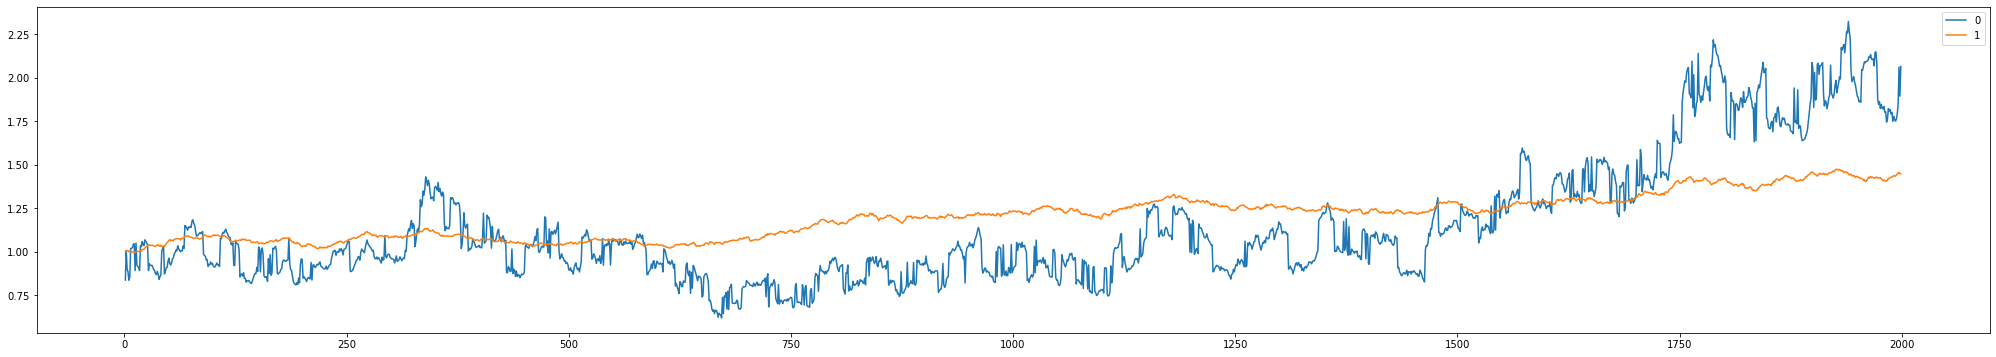

In [26]:
np.exp(np.log(df_equity_index).diff().cumsum()).plot(figsize=(35,6))

In [47]:
df_equity_index_ret=np.expm1(np.log(df_equity_index).diff())

In [58]:
_x=pd.DataFrame([
    rq.Risk(
        daily_returns=df_equity_index_ret.iloc[1:,0],
        benchmark_daily_returns=df_equity_index_ret.iloc[1:,1],
        risk_free_rate=1e-4,
    ).all(),
    rq.Risk(
        daily_returns=df_equity_index_ret.iloc[1:,1],
        benchmark_daily_returns=df_equity_index_ret.iloc[1:,1],
        risk_free_rate=1e-4,
    ).all(),
]).stack().unstack(0)
_x

,0,1
return,1.063012,0.447955
annual_return,0.095587,0.047768
benchmark_return,0.447955,0.447955
benchmark_annual_return,0.047768,0.047768
alpha,0.442571,0.000000
beta,0.601343,1.000000
sharpe,0.538466,0.777795
max_drawdown,0.567465,0.100187
volatility,0.055188,0.003929
annual_volatility,0.876086,0.062369


In [45]:
_x=pd.DataFrame([
    rq.Risk(
        daily_returns=equity_index_ret[:,0],
        benchmark_daily_returns=equity_index_ret[:,1],
        risk_free_rate=1e-4,
    ).all(),
    rq.Risk(
        daily_returns=equity_index_ret[:,1],
        benchmark_daily_returns=equity_index_ret[:,1],
        risk_free_rate=1e-4,
    ).all(),
]).stack().unstack(0)
_x

,0,1
return,1.063012,0.447955
annual_return,0.095587,0.047768
benchmark_return,0.447955,0.447955
benchmark_annual_return,0.047768,0.047768
alpha,0.442571,0.000000
beta,0.601343,1.000000
sharpe,0.538466,0.777795
max_drawdown,0.567465,0.100187
volatility,0.055188,0.003929
annual_volatility,0.876086,0.062369


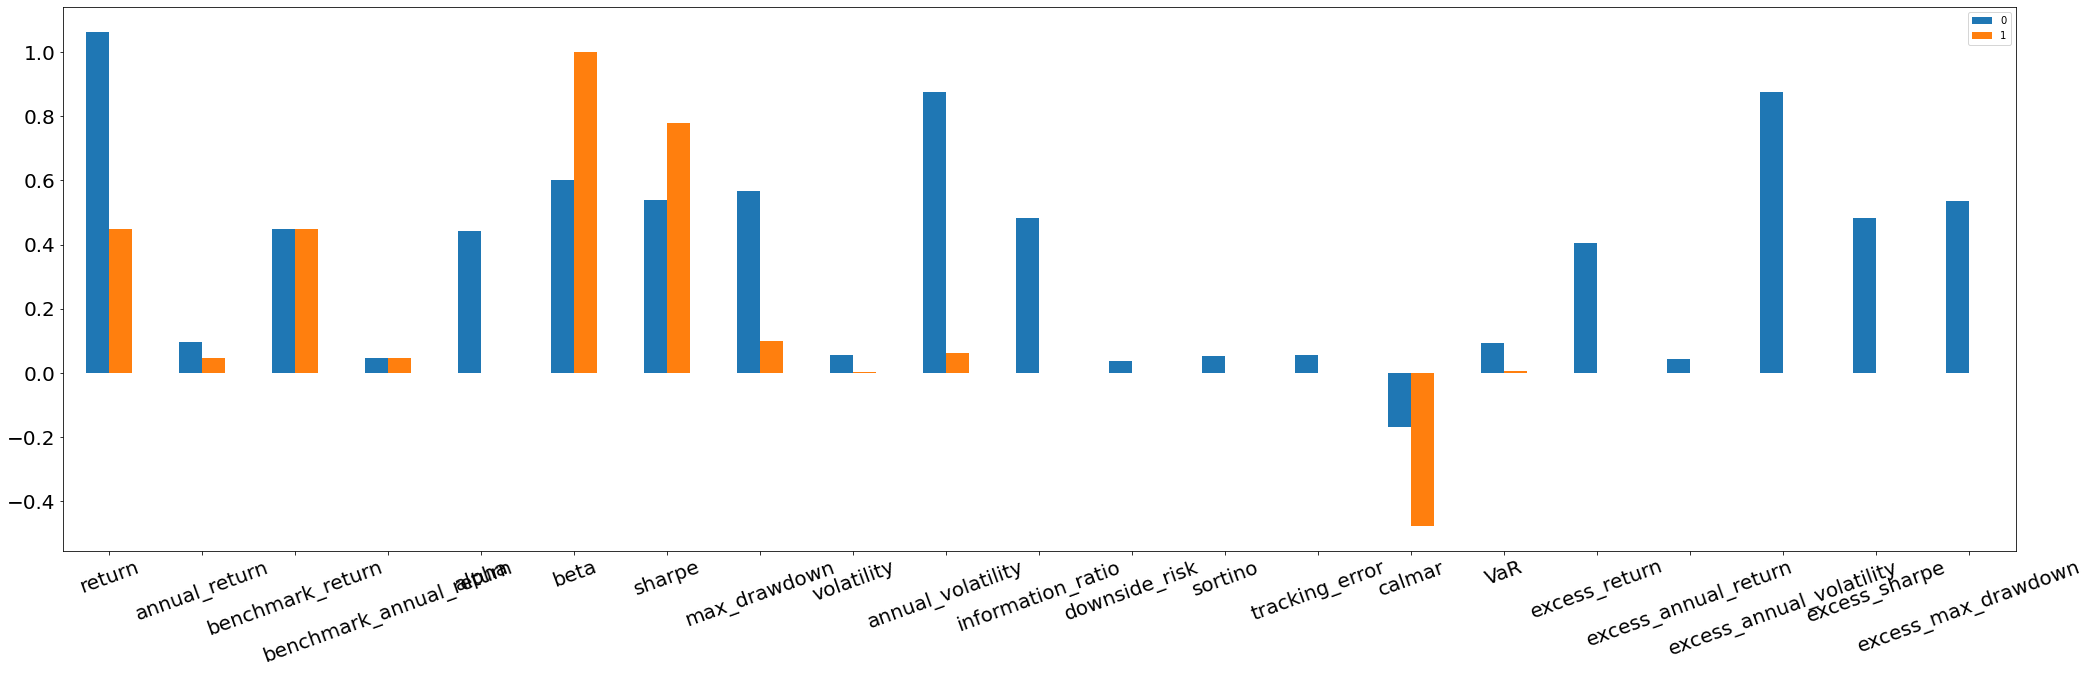

In [46]:
_x.plot.bar(figsize=(35,10))
plt.xticks(rotation=20)
plt.tick_params(labelsize=20)

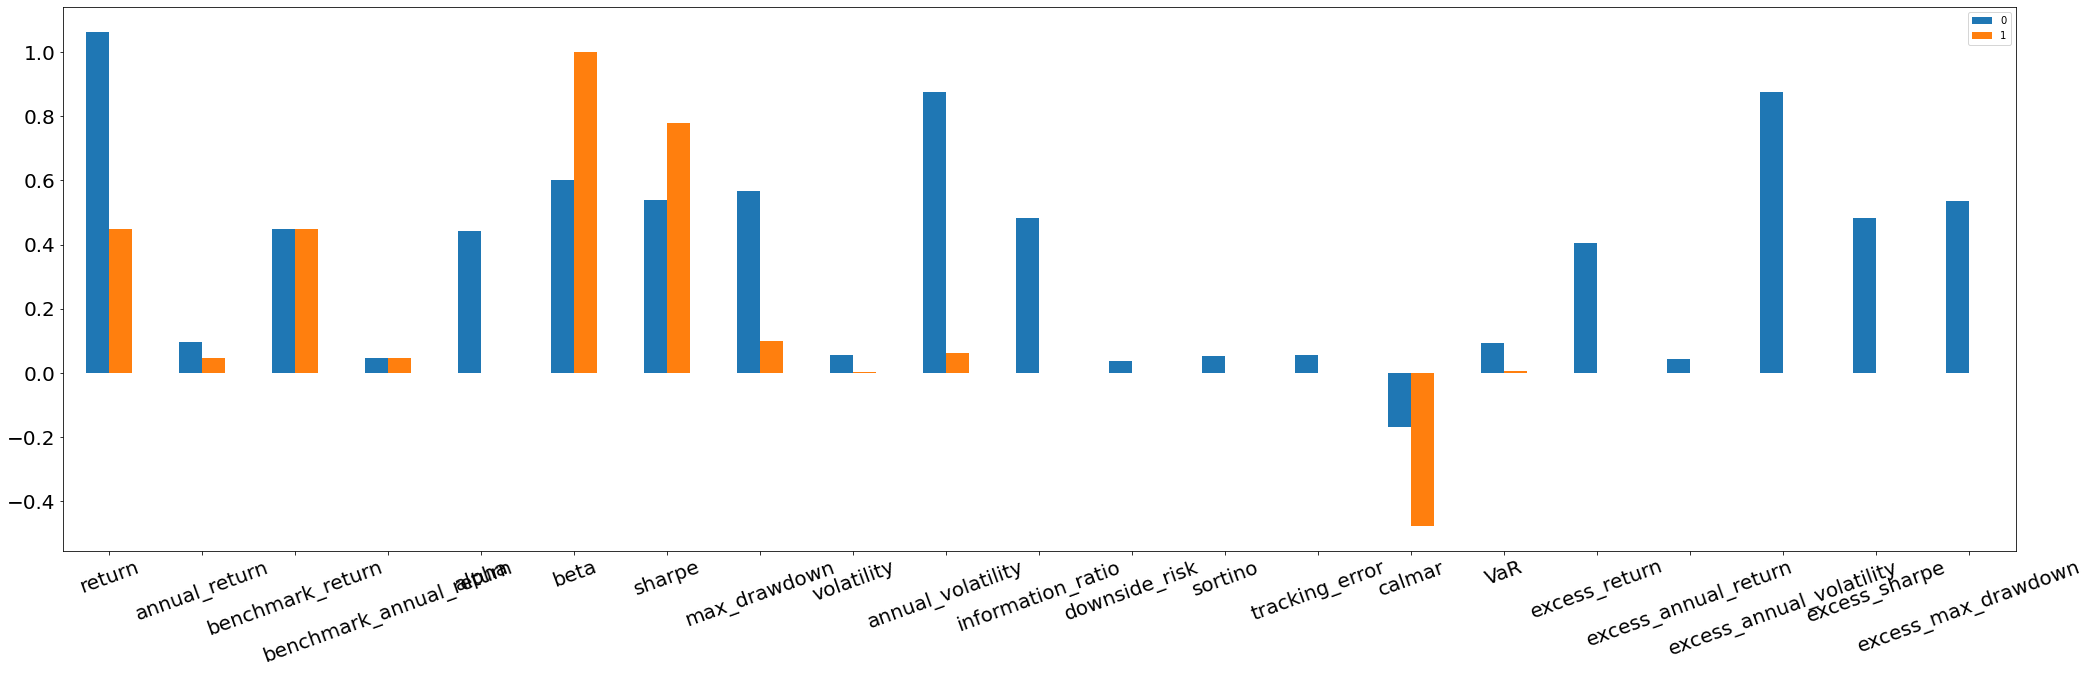

In [59]:
_x.plot.bar(figsize=(35,10))
plt.xticks(rotation=20)
plt.tick_params(labelsize=20)

# 策略优化

In [19]:
parameters=[5,10,15,20,25,30,]

In [20]:
def get_stg_ret(i):
    stg=Strategy(contract_num=len(s),period=i)
    app=xq.app.A0(stg=stg)
    _=list(app.route(x=i) for r in get_msg() for i in r)# 列表推导式
    equity=np.array(list(itertools.chain(stg.equity,[app.a.equity])))
    log_ret=np.log(equity)
    equity_ret=np.expm1(log_ret[1:]-log_ret[:-1])#算数收益率
    return equity_ret

In [21]:
_l=[]
for i in parameters:
    _l.append(
        rq.Risk(
            daily_returns=get_stg_ret(i),
            benchmark_daily_returns=equity_index_ret[:,1],
            risk_free_rate=1e-4,
        ).all(),
    )

In [22]:
_x=pd.DataFrame(_l).stack().unstack(0)
_x.columns=parameters
_x

,5,10,15,20,25,30
return,0.765913,1.318477,1.219991,1.063012,0.343484,0.142237
annual_return,0.074320,0.111830,0.105763,0.095587,0.037924,0.016906
benchmark_return,0.447955,0.447955,0.447955,0.447955,0.447955,0.447955
benchmark_annual_return,0.047768,0.047768,0.047768,0.047768,0.047768,0.047768
alpha,0.777430,0.567184,0.509379,0.442571,0.340549,0.297801
beta,0.091295,0.577221,0.594285,0.601343,0.504173,0.878809
sharpe,0.653087,0.599896,0.572023,0.538466,0.448509,0.421374
max_drawdown,0.541142,0.493833,0.554192,0.567465,0.550443,0.600272
volatility,0.075415,0.062499,0.059270,0.055188,0.051266,0.050894
annual_volatility,1.197173,0.992148,0.940884,0.876086,0.813823,0.807910


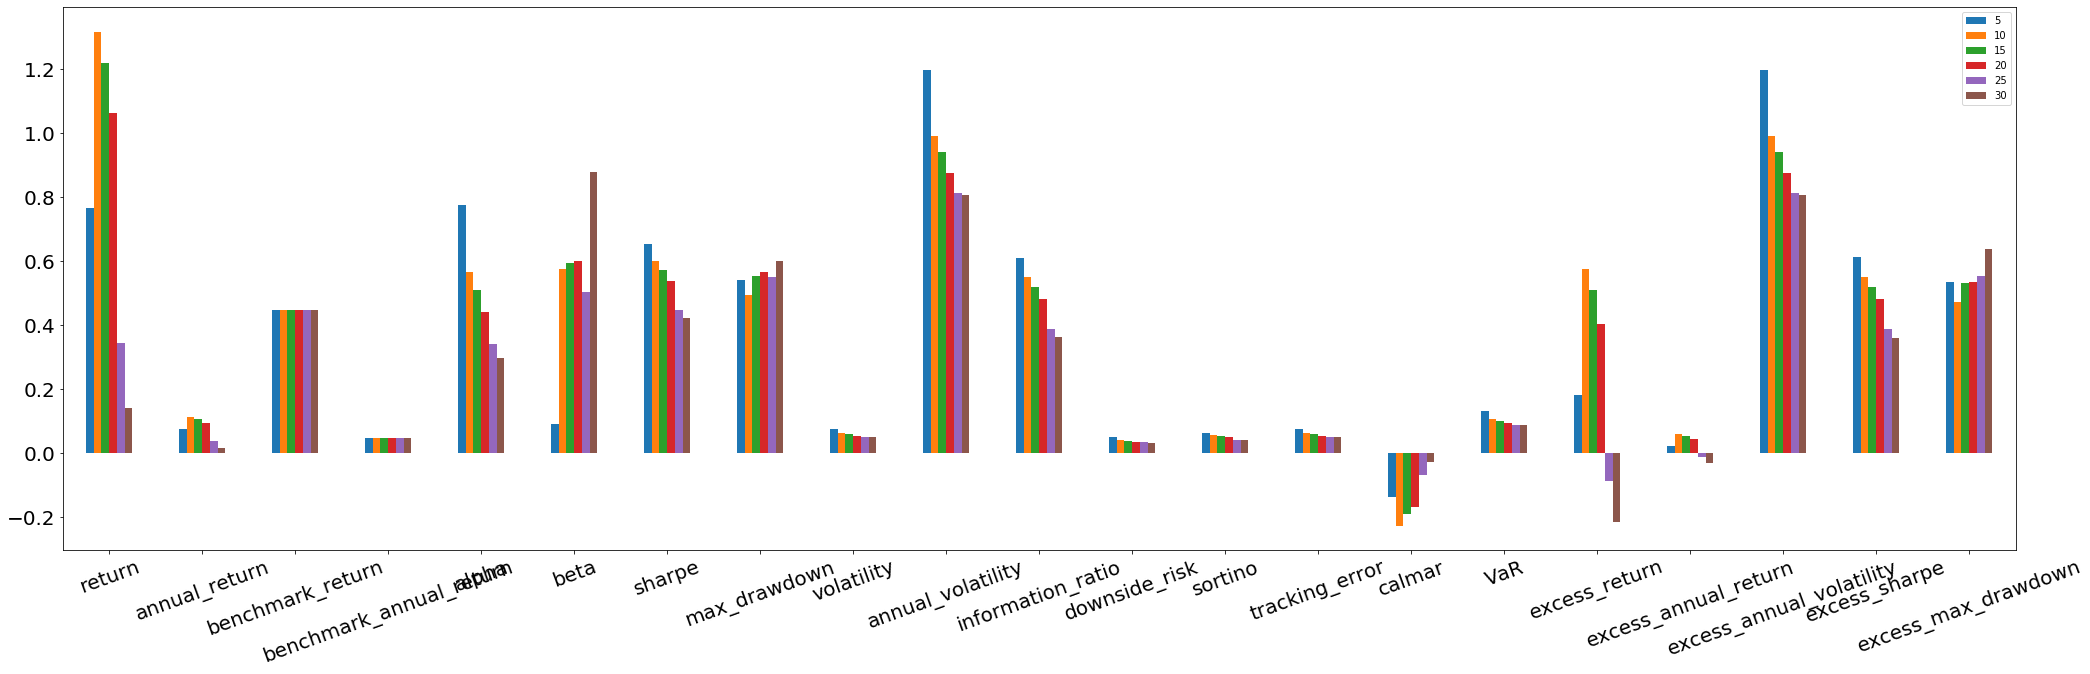

In [23]:
_x.plot.bar(figsize=(35,10))
plt.xticks(rotation=20)
plt.tick_params(labelsize=20)

**注：**
> 一般选择，对应绩效指标呈单调性/规律性（三维平原）的参数设定